In [10]:
%%px

ERROR:root:Cell magic `%%px` not found.


In [8]:
import numpy as np 

In [185]:
import ipyparallel as ipp

In [186]:
c = ipp.Client(profile='default')

In [187]:
c.ids

[0, 1, 2, 3, 4, 5, 6, 7]

In [188]:
dview = c[:]

 ```activate``` - make magics use the curent view

[output:0]

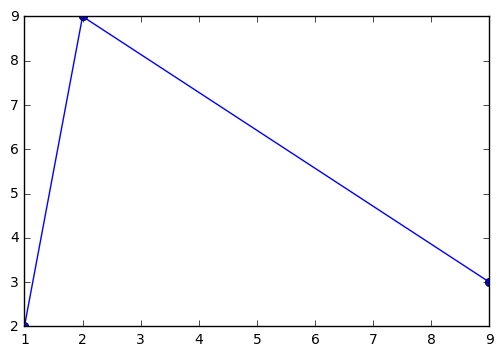

[output:1]

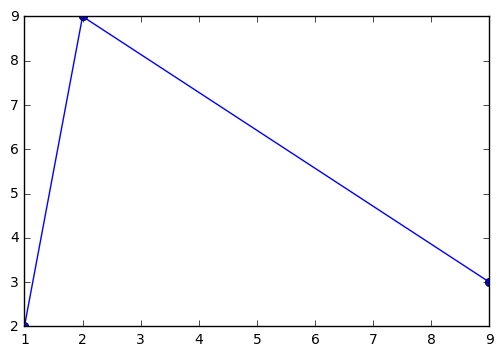

[output:2]

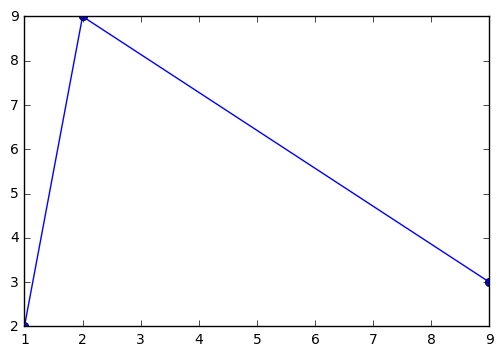

[output:3]

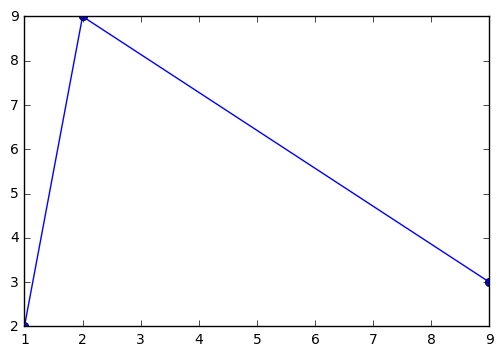

[output:4]

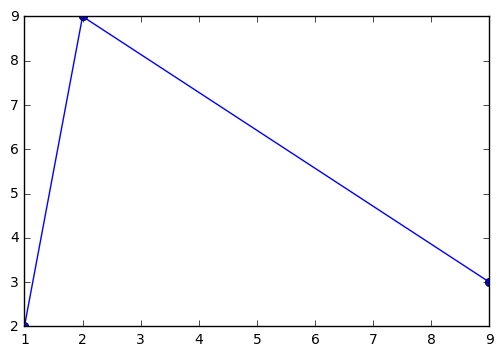

[output:5]

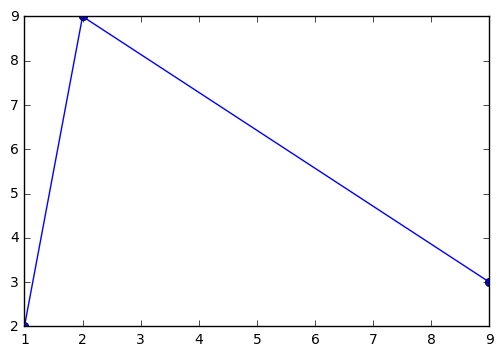

[output:6]

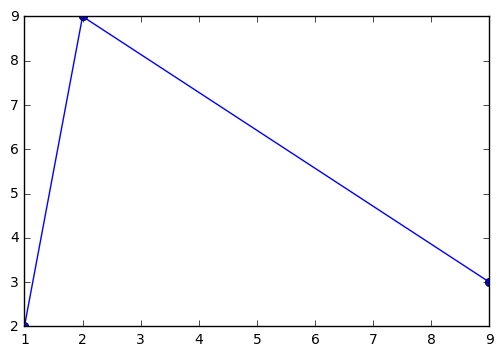

[output:7]

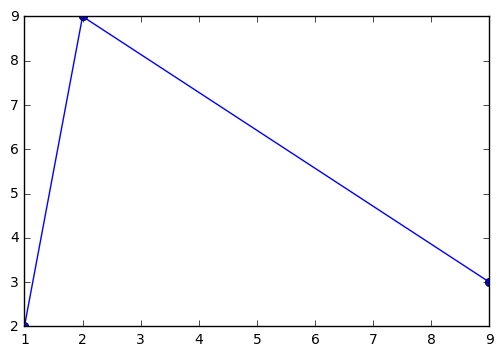

Out[0:11]: [<matplotlib.lines.Line2D at 0x7fda9810d630>]

Out[1:13]: [<matplotlib.lines.Line2D at 0x7f8c8c28a7b8>]

Out[2:12]: [<matplotlib.lines.Line2D at 0x7fcc9fca4cc0>]

Out[3:12]: [<matplotlib.lines.Line2D at 0x7fe8bcfabcf8>]

Out[4:11]: [<matplotlib.lines.Line2D at 0x7ff508147588>]

Out[5:11]: [<matplotlib.lines.Line2D at 0x7fb53a8c05f8>]

Out[6:11]: [<matplotlib.lines.Line2D at 0x7fab900d05f8>]

Out[7:11]: [<matplotlib.lines.Line2D at 0x7f18440dd6d8>]

In [196]:
%%px
%matplotlib inline
from pylab import *
plot([1,2,9],[2,9,3],'o-')

# @dview.remote

In [161]:
@dview.remote(block=True)
def getpid():
    import os
    return os.getpid()

In [163]:
getpid()

[140964, 140966, 140980, 140982, 140983, 140985, 140995, 141003]

In [177]:
@dview.remote(block=True)
def iterate_logistic(a,N,Niter):
    import numpy as np 
    x = np.random.random(N)
    for i in range(Niter):
        x = a*x*(1.0-x)
    return x


In [178]:
iterate_logistic(4.0,1,10000)

[array([ 0.59239529]),
 array([ 0.82177328]),
 array([ 0.83118776]),
 array([ 0.7666796]),
 array([ 0.29011016]),
 array([ 0.34051364]),
 array([ 0.73476606]),
 array([ 0.40354799])]

# @dview.parallel

In [153]:
import numpy as np
x = np.random.random((2**12))
print(x.nbytes/1024**2,x.size)
a = np.ones_like(x)*4.0

0.03125 4096


In [154]:
@dview.parallel(block=True)
def iterate_logistic(x,a):
    import numpy as np 
    x = np.copy(x)
    for i in range(100000):
        x = a*x*(1.0-x)
    return x


In [155]:
%%time
for i in range(100000):
    x = a*x*(1.0-x)


CPU times: user 852 ms, sys: 0 ns, total: 852 ms
Wall time: 848 ms


In [156]:
%time x = iterate_logistic(x,a)

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 355 ms


In [46]:
dview?

In [55]:
import ipyparallel.client.remotefunction
ipyparallel.client.remotefunction.ParallelFunction?

Configure `mpi` profile first:
 - http://ipyparallel.readthedocs.io/en/latest/process.html#parallel-process

In [4]:
c = ipp.Client(profile='mpi')

In [5]:
c.ids

[0, 1, 2, 3]

In [6]:
c[:].apply_sync(lambda : "Hello, World")

['Hello, World', 'Hello, World', 'Hello, World', 'Hello, World']

Interesting might be: 

```python
c = Client('/path/to/my/ipcontroller-client.json', sshserver='me@myhub.example.com')
```

In [7]:
import mpi4py

In [8]:
%%px

UsageError: %%px is a cell magic, but the cell body is empty. Did you mean the line magic %px (single %)?


In [9]:
%%writefile psum.py
from mpi4py import MPI
import numpy as np

def psum(a):
    locsum = np.sum(a)
    rcvBuf = np.array(0.0,'d')
    MPI.COMM_WORLD.Allreduce([locsum, MPI.DOUBLE],
        [rcvBuf, MPI.DOUBLE],
        op=MPI.SUM)
    return rcvBuf

Overwriting psum.py


In [10]:
view = c[:]

In [11]:
view.activate()

In [12]:
view.run('psum.py')

<AsyncResult: execute>

In [13]:
view.scatter('a',np.arange(16,dtype='float'))


<AsyncResult: scatter>

In [14]:
view['a']

[array([ 0.,  1.,  2.,  3.]),
 array([ 4.,  5.,  6.,  7.]),
 array([  8.,   9.,  10.,  11.]),
 array([ 12.,  13.,  14.,  15.])]

In [15]:
%px totalsum = psum(a)

<AsyncResult: execute>

In [16]:
view['totalsum']

[array(120.0), array(120.0), array(120.0), array(120.0)]

In [5]:
%%writefile psum.py
from mpi4py import MPI
import numpy as np

import time 
def psum(a):
    locsum = np.sum(a)
    rcvBuf = np.array(0.0,'d')
    MPI.COMM_WORLD.Allreduce([locsum, MPI.DOUBLE],
        [rcvBuf, MPI.DOUBLE],
        op=MPI.SUM)
    return rcvBuf

rank = MPI.COMM_WORLD.Get_rank()
size = MPI.COMM_WORLD.Get_size()
if rank==0:
    a = np.arange(16,dtype='float')
else:
    a = None
a_local = np.empty(16/size,dtype='float')   
MPI.COMM_WORLD.Scatter( a, a_local )
time.sleep(rank*0.1)
print(rank,":::",a_local)

totalsum = psum(a_local)
print(totalsum)

Overwriting psum.py


In [6]:
!mpirun -n 4 /opt/conda/envs/py27/bin/python psum.py


(0, ':::', array([ 0.,  1.,  2.,  3.]))
(1, ':::', array([ 4.,  5.,  6.,  7.]))
(2, ':::', array([  8.,   9.,  10.,  11.]))
(3, ':::', array([ 12.,  13.,  14.,  15.]))
120.0
120.0
120.0
120.0
